# Vehicle Detection

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
ROOT_PATH = Path('/home/downloads/carnd-p5-vehicle-detection')

## HOG Features

In [3]:
img_car_path = ROOT_PATH/'images/examples/car.png'
img_notcar_path = ROOT_PATH/'images/examples/notcar.png'

img_car = plt.imread(img_car_path.as_posix())
img_notcar = plt.imread(img_notcar_path.as_posix())

Image shape (64, 64, 3)


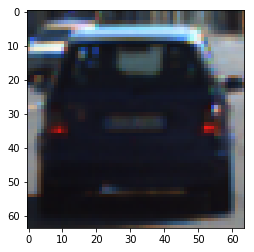

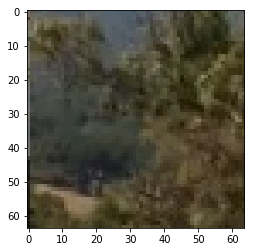

In [4]:
print('Image shape', img_car.shape)
plt.imshow(img_car)
plt.show()
plt.imshow(img_notcar)
plt.show()

In [5]:
def vis_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                    feature_vec=False):
    
    hog_img = None
    if vis:
        hog_features, hog_img = hog(img, orientations=orient, 
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block),
                                visualize=vis, feature_vector=feature_vec, block_norm='L2-Hys')
    else:
        hog_features = hog(img, orientations=orient, 
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block),
                        visualize=vis, feature_vector=feature_vec, block_norm='L2-Hys')
    return hog_features, hog_img

In [6]:
gray = cv2.cvtColor(img_car, cv2.COLOR_RGB2GRAY)
features, hog_img = vis_hog_features(gray, orient=9, 
                                         pix_per_cell= 8, cell_per_block= 2, 
                                         vis=True, feature_vec=False)

In [7]:
print('Shape of features array: ', features.shape)

Shape of features array:  (7, 7, 2, 2, 9)


Text(0.5,1,'HOG Visualization')

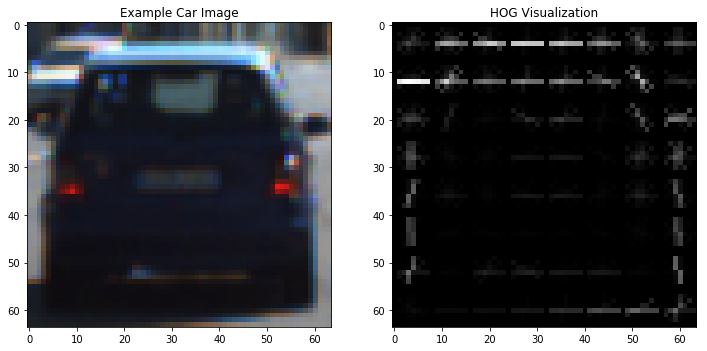

In [8]:
# Plot the examples
fig = plt.figure(figsize=(12, 9))
plt.subplot(121)
plt.imshow(img_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG Visualization')

## Features Classify

Three features are considered:
1. Spatial bins
2. histogram
3. HOG

In [9]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

def convert_color_rgb(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        cvt_image = np.copy(image)
    
    return cvt_image

def extract_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

In [10]:
def extract_features(image, cspace='RGB', orient=9, pix_per_cell=8, 
                     spatial_size=(32, 32), hist_bins=32,
                     cell_per_block=2, hog_channel=0, spatial_feat=True,
                     hist_feat=True, hog_feat=True):
    feature_image = convert_color_rgb(image, cspace)
    
    img_features = []
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for ch in range(feature_image.shape[2]):
                hog_features_ch = extract_hog_features(image[:, :, ch],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True)
                hog_features.append(hog_features_ch)
            hog_features = np.ravel(hog_features)
        
        else:
            hog_features = extract_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, 
                                                vis=False, feature_vec=True)
        img_features.append(hog_features)
        
    return np.concatenate(img_features)

In [11]:
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
spatial_feat = True
hist_feat = True
hog_feat = True
hist_bins = 32

In [12]:
extract_features(img_car)

array([0.15588236, 0.18529412, 0.23039216, ..., 0.        , 0.01711463,
       0.16758974])

Read images with cars and without cars

In [13]:
CAR_IMAGES_PATH = ROOT_PATH/'data/vehicles/KITTI_extracted'
NOTCAR_IMAGES_PATH = ROOT_PATH/'data/non-vehicles/GTI'

print('Total car images: ', len(list(CAR_IMAGES_PATH.iterdir())))
print('Not car iMages: ', len(list(NOTCAR_IMAGES_PATH.iterdir())))

Total car images:  5968
Not car iMages:  3901


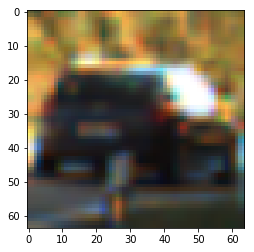

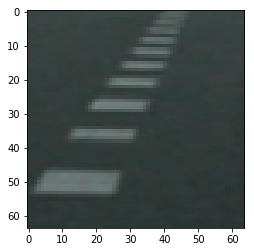

In [14]:
SAMPLE_SIZE = 1000

car_features = []
for file in CAR_IMAGES_PATH.glob('*png'):
    if len(car_features) > SAMPLE_SIZE:
        break
    
    img = plt.imread(file.as_posix())
    hog_features =  extract_features(img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    car_features.append(hog_features)
plt.imshow(img)
plt.show()

notcar_features = []
for file in NOTCAR_IMAGES_PATH.glob('*png'):
    if len(notcar_features) > SAMPLE_SIZE:
        break
        
    img = plt.imread(file.as_posix())
    hog_features =  extract_features(img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features.append(hog_features)
plt.imshow(img)
plt.show()

In [15]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('Shape of X: ', X.shape)

Shape of X:  (2002, 8460)


In [16]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('Shape of y: ', y.shape)

Shape of y:  (2002,)


Random split

In [17]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

In [18]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

Training

In [19]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
0.85 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1.]
For these 100 labels:  [1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1.]
0.00439 Seconds to predict 100 labels with SVC


## Sliding windows

In [20]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [21]:
def slide_window(img, x_start_stop=[0, None], y_start_stop=[0, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    # number of windows in x and y
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    window_list = []
    for xs in range(nx_windows):
        for ys in range(ny_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
    
    return window_list

In [22]:
test_image_path = ROOT_PATH/'images/test_images/test1.jpg'
test_image = plt.imread(test_image_path.as_posix())

In [23]:
windows = slide_window(test_image, xy_window=(128, 128), xy_overlap=(0.5, 0.5))

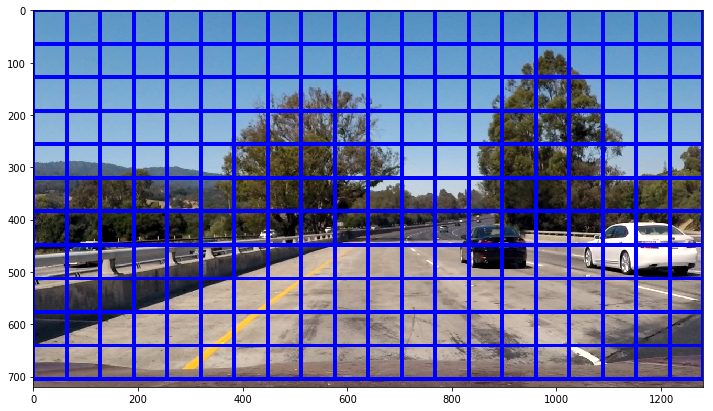

In [24]:
img = draw_boxes(test_image, windows)
plt.figure(figsize=(12,9))
plt.imshow(img)

## Search and classify

In [34]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        print(window)
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      

        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            print(features.shape)
            plt.imshow(test_img)
            plt.show()
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

((0, 0), (128, 128))
(8460,)


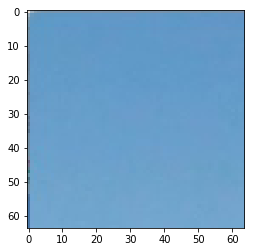

((0, 64), (128, 192))
(8460,)


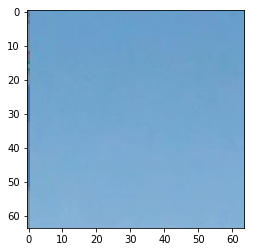

((0, 128), (128, 256))
(8460,)


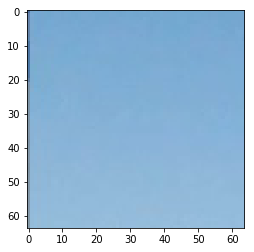

((0, 192), (128, 320))
(8460,)


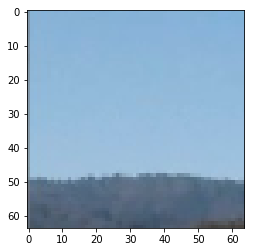

((0, 256), (128, 384))
(8460,)


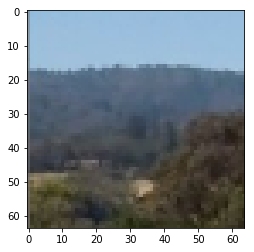

((0, 320), (128, 448))
(8460,)


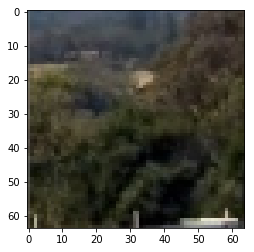

((0, 384), (128, 512))
(8460,)


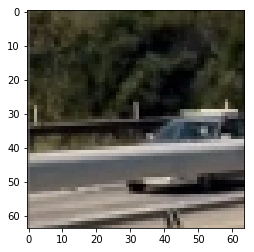

((0, 448), (128, 576))
(8460,)


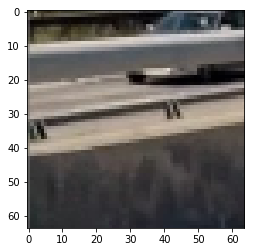

((0, 512), (128, 640))
(8460,)


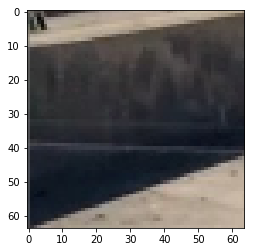

((0, 576), (128, 704))
(8460,)


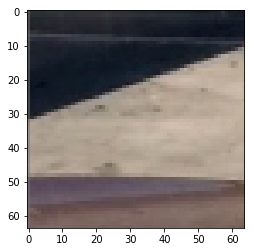

((64, 0), (192, 128))
(8460,)


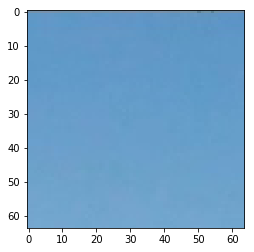

((64, 64), (192, 192))
(8460,)


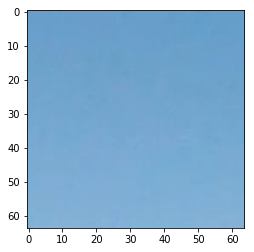

((64, 128), (192, 256))
(8460,)


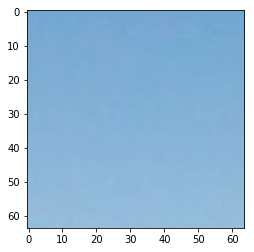

((64, 192), (192, 320))
(8460,)


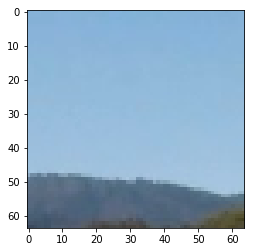

((64, 256), (192, 384))
(8460,)


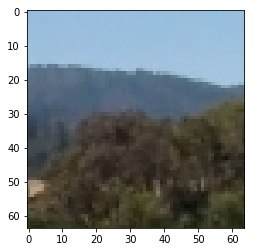

((64, 320), (192, 448))
(8460,)


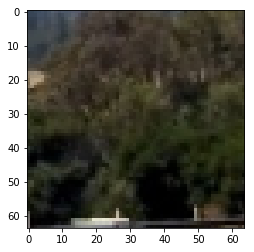

((64, 384), (192, 512))
(8460,)


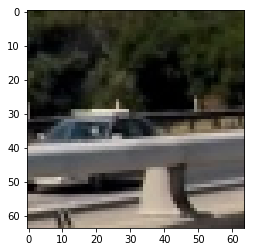

((64, 448), (192, 576))
(8460,)


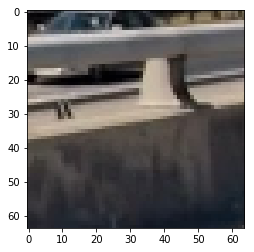

((64, 512), (192, 640))
(8460,)


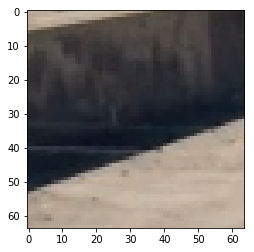

((64, 576), (192, 704))
(8460,)


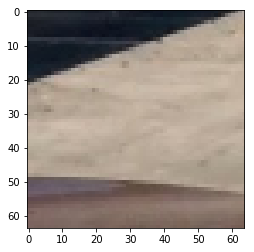

((128, 0), (256, 128))
(8460,)


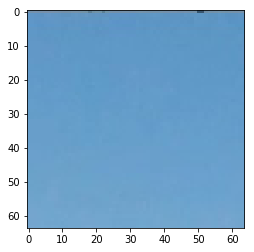

((128, 64), (256, 192))
(8460,)


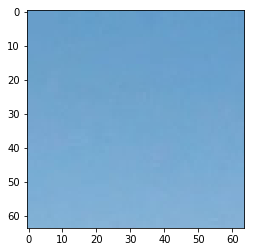

((128, 128), (256, 256))
(8460,)


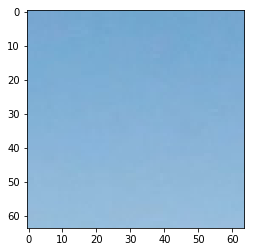

((128, 192), (256, 320))
(8460,)


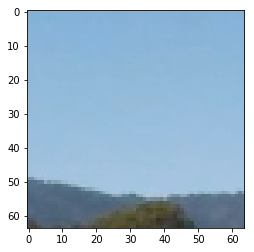

((128, 256), (256, 384))
(8460,)


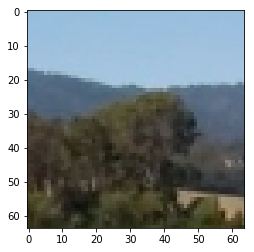

((128, 320), (256, 448))
(8460,)


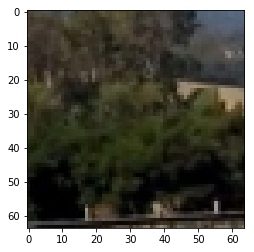

((128, 384), (256, 512))
(8460,)


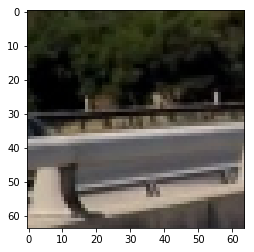

((128, 448), (256, 576))
(8460,)


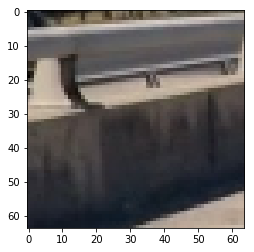

((128, 512), (256, 640))
(8460,)


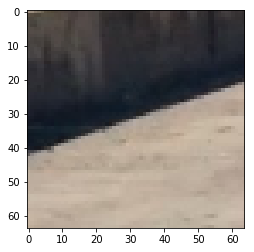

((128, 576), (256, 704))
(8460,)


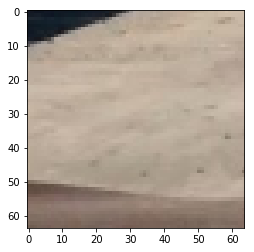

((192, 0), (320, 128))
(8460,)


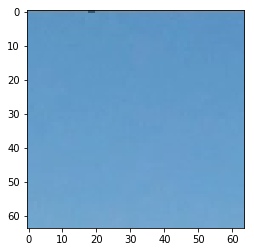

((192, 64), (320, 192))
(8460,)


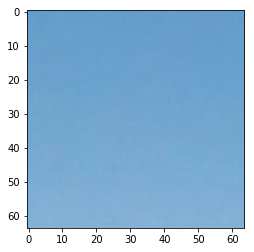

((192, 128), (320, 256))
(8460,)


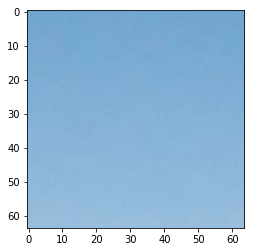

((192, 192), (320, 320))
(8460,)


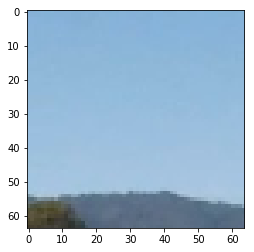

((192, 256), (320, 384))
(8460,)


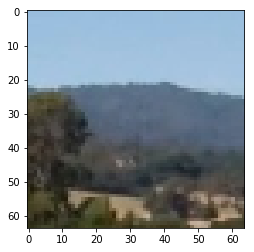

((192, 320), (320, 448))
(8460,)


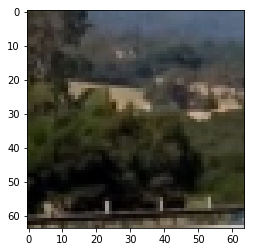

((192, 384), (320, 512))
(8460,)


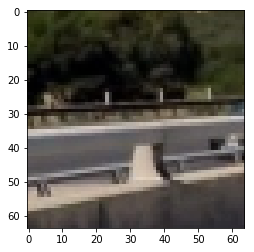

((192, 448), (320, 576))
(8460,)


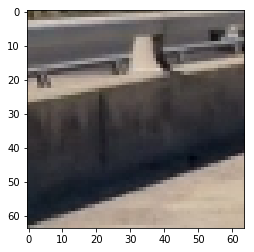

((192, 512), (320, 640))
(8460,)


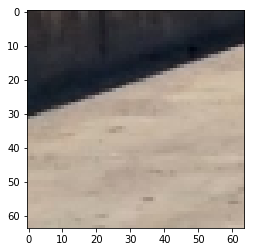

((192, 576), (320, 704))
(8460,)


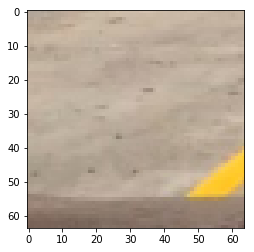

((256, 0), (384, 128))
(8460,)


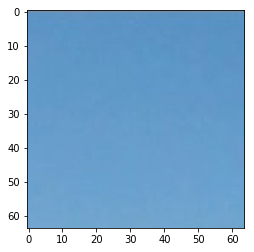

((256, 64), (384, 192))
(8460,)


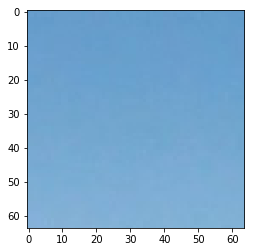

((256, 128), (384, 256))
(8460,)


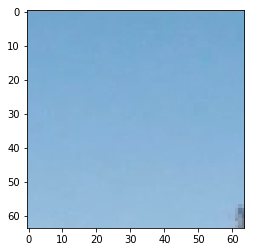

((256, 192), (384, 320))
(8460,)


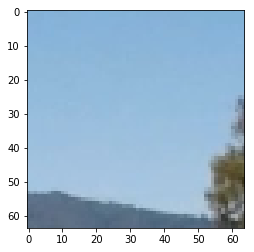

((256, 256), (384, 384))
(8460,)


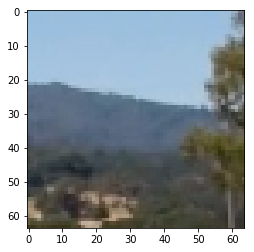

((256, 320), (384, 448))
(8460,)


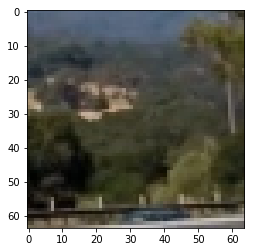

((256, 384), (384, 512))
(8460,)


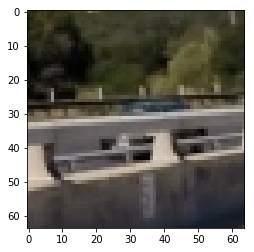

((256, 448), (384, 576))
(8460,)


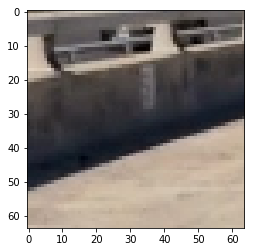

((256, 512), (384, 640))
(8460,)


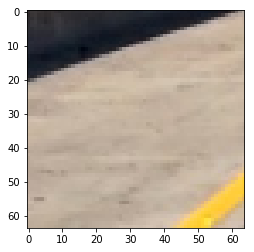

((256, 576), (384, 704))
(8460,)


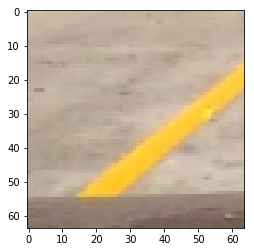

((320, 0), (448, 128))
(8460,)


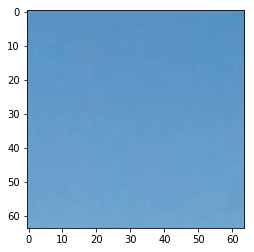

((320, 64), (448, 192))
(8460,)


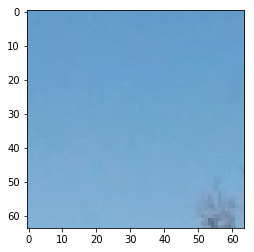

((320, 128), (448, 256))
(8460,)


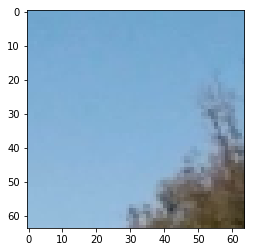

((320, 192), (448, 320))
(8460,)


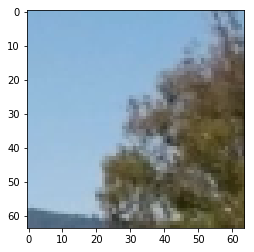

((320, 256), (448, 384))
(8460,)


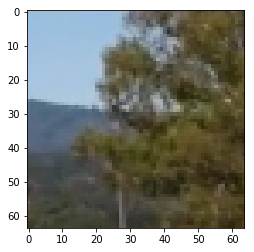

((320, 320), (448, 448))
(8460,)


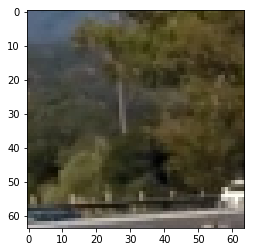

((320, 384), (448, 512))
(8460,)


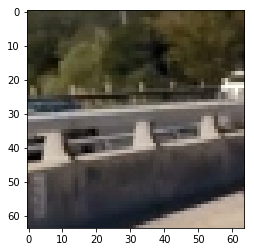

((320, 448), (448, 576))
(8460,)


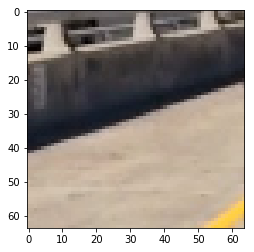

((320, 512), (448, 640))
(8460,)


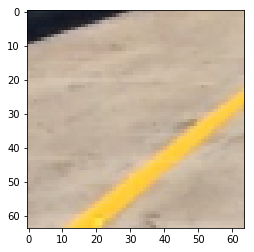

((320, 576), (448, 704))
(8460,)


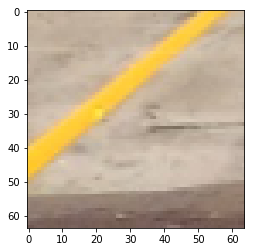

((384, 0), (512, 128))
(8460,)


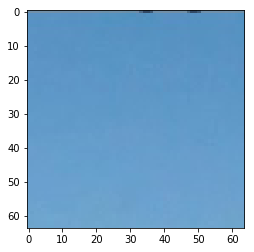

((384, 64), (512, 192))
(8460,)


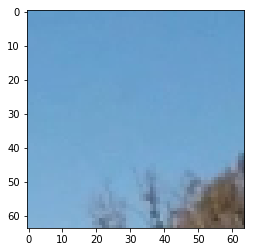

((384, 128), (512, 256))
(8460,)


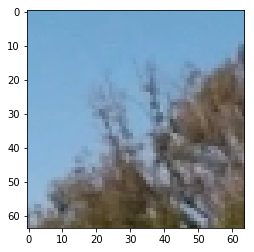

((384, 192), (512, 320))
(8460,)


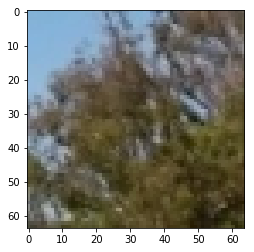

((384, 256), (512, 384))
(8460,)


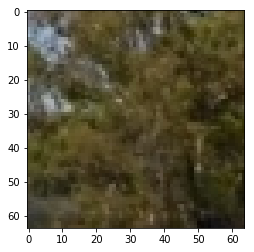

((384, 320), (512, 448))
(8460,)


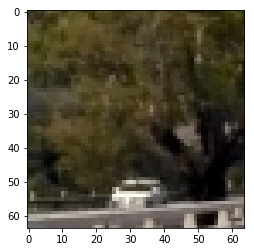

((384, 384), (512, 512))
(8460,)


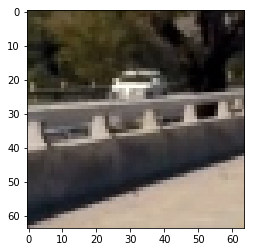

((384, 448), (512, 576))
(8460,)


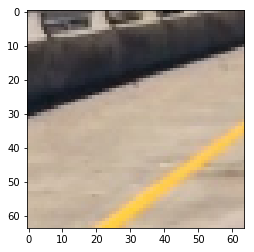

((384, 512), (512, 640))
(8460,)


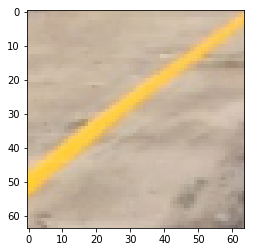

((384, 576), (512, 704))
(8460,)


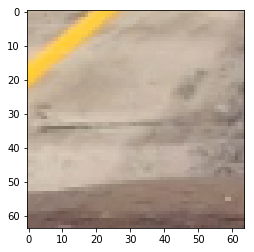

((448, 0), (576, 128))
(8460,)


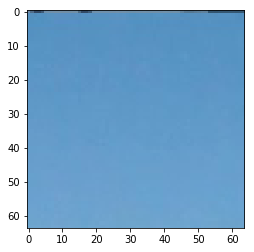

((448, 64), (576, 192))
(8460,)


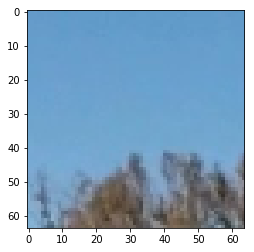

((448, 128), (576, 256))
(8460,)


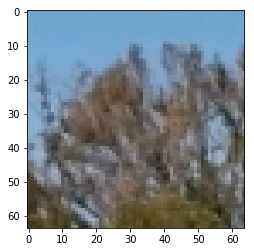

((448, 192), (576, 320))
(8460,)


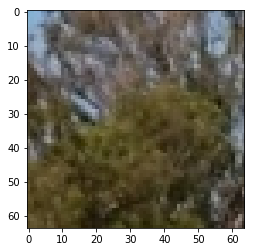

((448, 256), (576, 384))
(8460,)


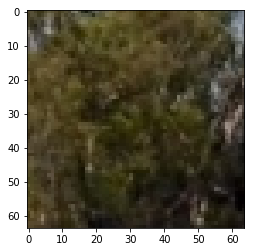

((448, 320), (576, 448))
(8460,)


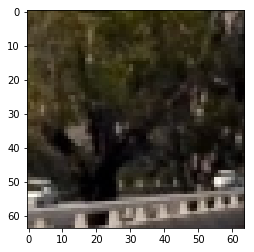

((448, 384), (576, 512))
(8460,)


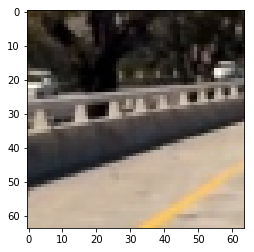

((448, 448), (576, 576))
(8460,)


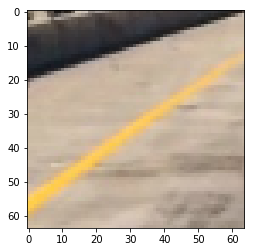

((448, 512), (576, 640))
(8460,)


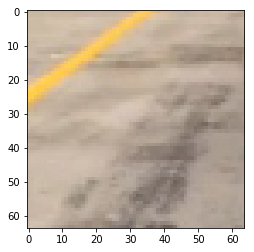

((448, 576), (576, 704))
(8460,)


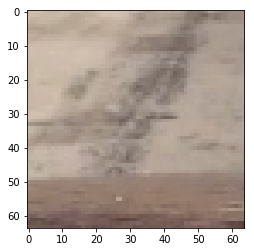

((512, 0), (640, 128))
(8460,)


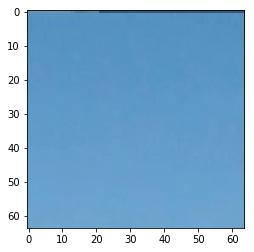

((512, 64), (640, 192))
(8460,)


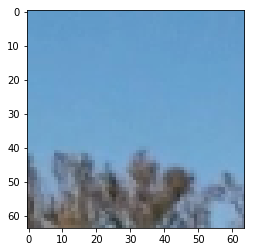

((512, 128), (640, 256))
(8460,)


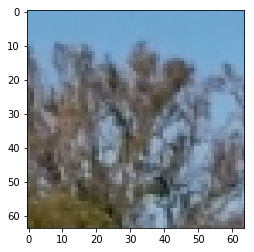

((512, 192), (640, 320))
(8460,)


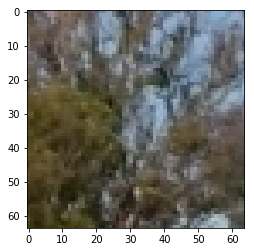

((512, 256), (640, 384))
(8460,)


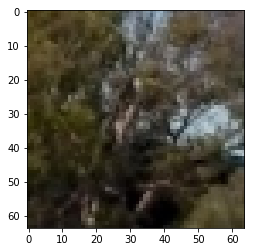

((512, 320), (640, 448))
(8460,)


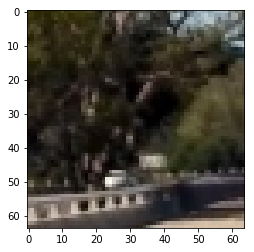

((512, 384), (640, 512))
(8460,)


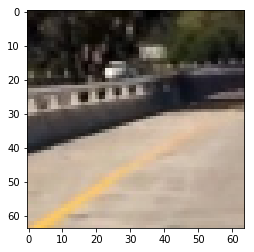

((512, 448), (640, 576))
(8460,)


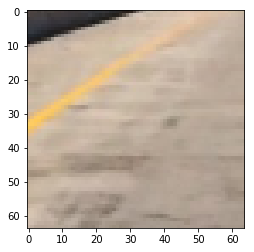

((512, 512), (640, 640))
(8460,)


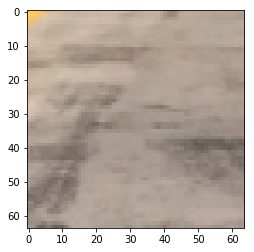

((512, 576), (640, 704))
(8460,)


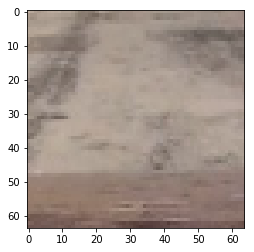

((576, 0), (704, 128))
(8460,)


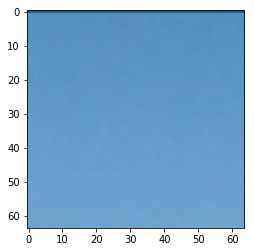

((576, 64), (704, 192))
(8460,)


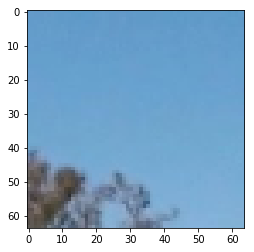

((576, 128), (704, 256))
(8460,)


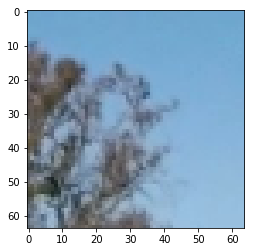

((576, 192), (704, 320))
(8460,)


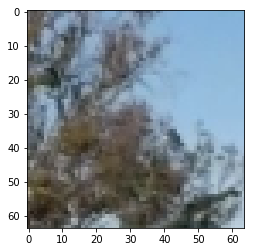

((576, 256), (704, 384))
(8460,)


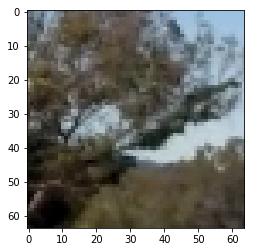

((576, 320), (704, 448))
(8460,)


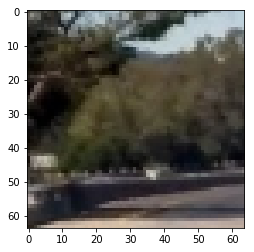

((576, 384), (704, 512))
(8460,)


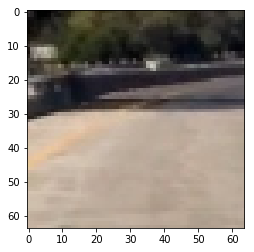

((576, 448), (704, 576))
(8460,)


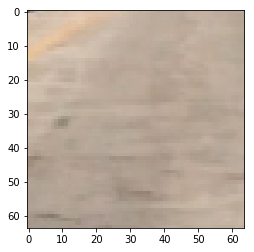

((576, 512), (704, 640))
(8460,)


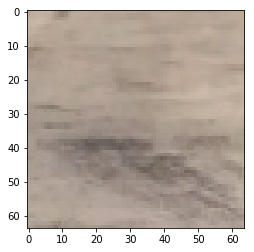

((576, 576), (704, 704))
(8460,)


KeyboardInterrupt: 

In [35]:
hot_windows = search_windows(test_image, windows, svc, X_scaler, cspace=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)    

In [ ]:
img = draw_boxes(test_image, hot_windows)
plt.figure(figsize=(12,9))
plt.imshow(img)

### Multiple detections and false positive

In [65]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [76]:
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

heat = add_heat(heat, hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

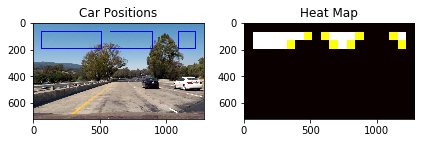

In [77]:
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

### HOG Subsampling

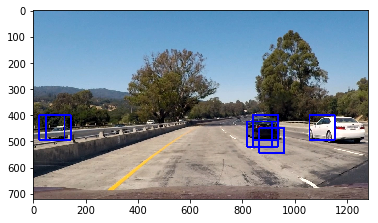

In [32]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color_rgb(img_tosearch, cspace='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = extract_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = extract_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = extract_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
spatial_size = (32, 32)
hist_bins = 32
    
out_img = find_cars(test_image, ystart, ystop, scale, svc, X_scaler,
                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)